# Split oxygen-vacancy defects in Co
We want to work out the symmetry analysis for our split oxygen-vacancy (V-O-V) defects $\alpha$-Co (HCP) and $\beta$-Co (FCC).

The split defects can be represented simply as crowdion interstitial sites, for the purposes of symmetry analysis. We're interested in extracting the tensor expansions around those sites, and (eventually) computing the damping coefficients from the DFT data.

In [1]:
import sys
sys.path.extend(['../'])
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
import onsager.crystal as crystal
import onsager.OnsagerCalc as onsager
from scipy.constants import physical_constants
kB = physical_constants['Boltzmann constant in eV/K'][0]

In [2]:
betaCo = crystal.Crystal.FCC(1.0, 'Co')
print(betaCo)

#Lattice:
  a1 = [ 0.   0.5  0.5]
  a2 = [ 0.5  0.   0.5]
  a3 = [ 0.5  0.5  0. ]
#Basis:
  (Co) 0.0 = [ 0.  0.  0.]


In [3]:
betaCo.Wyckoffpos(np.array([0.5,0.,0.]))

[array([ 0. ,  0. ,  0.5]),
 array([ 0.5,  0. ,  0.5]),
 array([ 0.5,  0. ,  0. ]),
 array([ 0. ,  0.5,  0. ]),
 array([ 0.5,  0.5,  0. ]),
 array([ 0. ,  0.5,  0.5])]

In [4]:
betaCoO = betaCo.addbasis(betaCo.Wyckoffpos(np.array([0.5,0.,0.])), ['O'])
print(betaCoO)

#Lattice:
  a1 = [ 0.   0.5  0.5]
  a2 = [ 0.5  0.   0.5]
  a3 = [ 0.5  0.5  0. ]
#Basis:
  (Co) 0.0 = [ 0.  0.  0.]
  (O) 1.0 = [ 0.   0.   0.5]
  (O) 1.1 = [ 0.5  0.   0.5]
  (O) 1.2 = [ 0.5  0.   0. ]
  (O) 1.3 = [ 0.   0.5  0. ]
  (O) 1.4 = [ 0.5  0.5  0. ]
  (O) 1.5 = [ 0.   0.5  0.5]


In [5]:
Ojumpnetwork = betaCoO.jumpnetwork(1,0.5)

In [6]:
Odiffuser = onsager.Interstitial(betaCoO, 1, betaCoO.sitelist(1), Ojumpnetwork)

We need to analyze the geometry of our representative site; we get the position, then find the zero entry in the position vector, and work from there.

In [7]:
Ppara, Pperp, Pshear = -2.70, -4.30, 0.13
reppos = betaCoO.pos2cart(np.zeros(3), (1, Odiffuser.sitelist[0][0]))
perpindex = [n for n in range(3) if np.isclose(reppos[n], 0)][0]
paraindex = [n for n in range(3) if n != perpindex]
shearsign = 1 if reppos[paraindex[0]]*reppos[paraindex[1]] > 0 else -1
Pdipole = np.diag([Pperp if n == perpindex else Ppara for n in range(3)])
Pdipole[paraindex[0], paraindex[1]] = shearsign*Pshear
Pdipole[paraindex[1], paraindex[0]] = shearsign*Pshear
Pdipole

array([[-2.7 ,  0.13,  0.  ],
       [ 0.13, -2.7 ,  0.  ],
       [ 0.  ,  0.  , -4.3 ]])

In [8]:
nu0, Emig = 1e13, 0.91
nsites, njumps = len(Odiffuser.sitelist), len(Odiffuser.jumpnetwork)
betaCoOthermodict = {'pre': np.ones(nsites), 'ene': np.zeros(nsites), 
                     'preT': nu0*np.ones(nsites), 'eneT': Emig*np.ones(nsites)}
beta = 1./(kB*300)  # 300K
Llamb = Odiffuser.losstensors(betaCoOthermodict['pre'], beta*betaCoOthermodict['ene'], 
                              [Pdipole], 
                              betaCoOthermodict['preT'], beta*betaCoOthermodict['eneT'])

In [9]:
for (lamb, Ltens) in Llamb:
    print(lamb, crystal.FourthRankIsotropic(Ltens))

0.0619225494951 (0.0, 0.17066666666666686)
0.0412816996634 (2.4132664014743868e-32, 0.0033799999999999629)


In [10]:
sh1 = crystal.FourthRankIsotropic(Llamb[0][1])[1]
sh2 = crystal.FourthRankIsotropic(Llamb[1][1])[1]
print(sh2/sh1)

0.0198046875


Internal friction resonance. We do loading at a frequency of 1 Hz.

In [11]:
nuIF = 1.
Trange = np.linspace(250,400,151)
shlist = []
for T in Trange:
    beta = 1./(kB*T)
    Llamb = Odiffuser.losstensors(betaCoOthermodict['pre'], beta*betaCoOthermodict['ene'], 
                                  [Pdipole], 
                                  betaCoOthermodict['preT'], beta*betaCoOthermodict['eneT'])
    f1,L1,f2,L2 = Llamb[0][0], Llamb[0][1], Llamb[1][0], Llamb[1][1]
    sh = crystal.FourthRankIsotropic(L1*nuIF*f1/(nuIF**2+f1**2) + 
                                     L2*nuIF*f2/(nuIF**2+f2**2))[1]
    shlist.append(sh*kB*T)
shear = np.array(shlist)

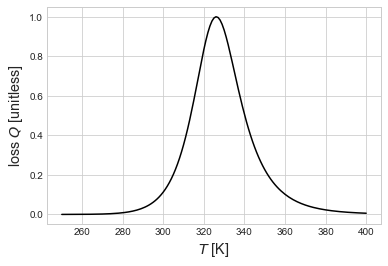

In [12]:
fig, ax1 = plt.subplots()
ax1.plot(Trange, shear/np.max(shear), 'k')
ax1.set_ylabel('loss $Q$ [unitless]', fontsize='x-large')
ax1.set_xlabel('$T$ [K]', fontsize='x-large')
plt.show()
# plt.savefig('FCC-Co-O-loss.pdf', transparent=True, format='pdf')

Temperature where peak maximum is found?

In [13]:
Trange[np.argmax(shear)]

326.0